# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics, color, io
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512 $\times$ 512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


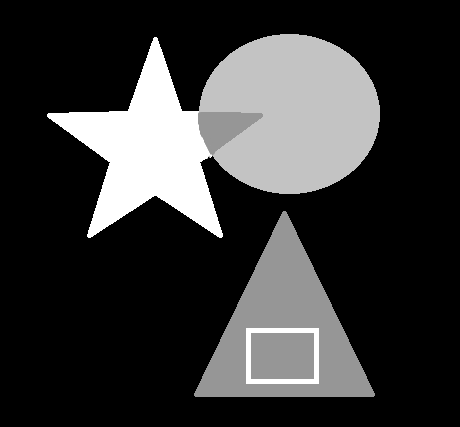


In [2]:
# Font per pyplot
plt.rcParams.update({'font.size': 15})

# Alias per le funzioni
f_MSE = metrics.mean_squared_error
f_PSNR = metrics.peak_signal_noise_ratio


## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

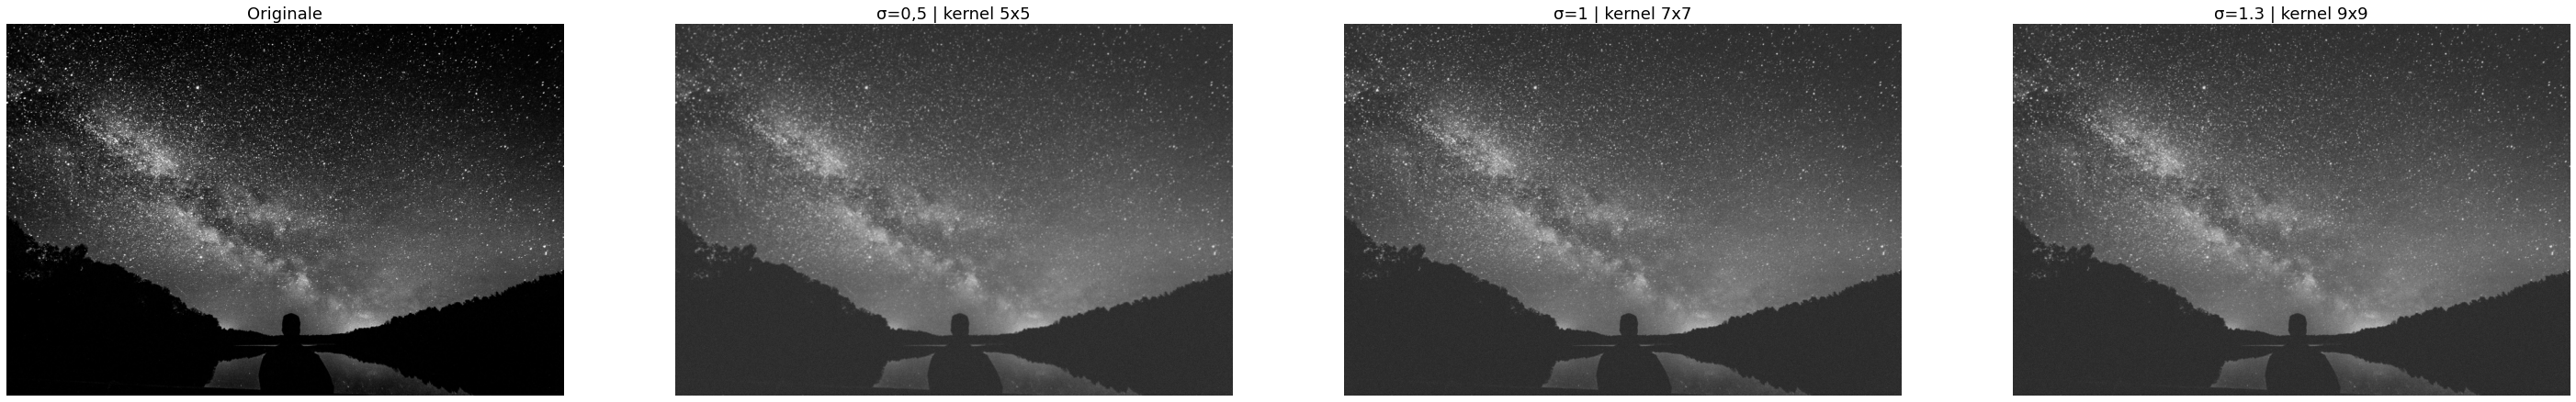

In [36]:
def gaussian_blur(image_size, kernel_len, sigma):
    """
        Restituisce l'operatore di blur
    """
    return psf_fft(gaussian_kernel(kernel_len, sigma), kernel_len, image_size)


# real_image = data.camera().astype(np.float64) / 255.0
# real_image = plt.imread("./dataset/image1.png").astype(np.float64)
# real_image = plt.imread("./dataset/NotteStellata.jpg").astype(np.float64)
real_image = plt.imread("./dataset/CieloStellato.jpg").astype(np.float64)

real_image = color.rgb2gray(real_image)
real_image = real_image / np.max(real_image)

# Filtro blur (A)
blur1 = gaussian_blur(real_image.shape, 25, 3)
# blur1 = gaussian_blur(real_image.shape, 65, 15)
blur2 = gaussian_blur(real_image.shape, 7, 1)
blur3 = gaussian_blur(real_image.shape, 9, 1.3)

# Filtro rumore (η)
dev = 0.05
noise = np.random.normal(size=real_image.shape) * dev

image1 = A(real_image, blur1) + noise
image2 = A(real_image, blur2) + noise
image3 = A(real_image, blur3) + noise


fig, ax = plt.subplots(1, 4, figsize=(50, 50))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0].imshow(real_image, cmap="gray")
ax[0].set_title("Originale")
ax[0].axis("off")

ax[1].imshow(image1, cmap="gray")
ax[1].set_title("σ=0,5 | kernel 5x5")
ax[1].axis("off")

ax[2].imshow(image2, cmap="gray")
ax[2].set_title("σ=1 | kernel 7x7")
ax[2].axis("off")

ax[3].imshow(image3, cmap="gray")
ax[3].set_title("σ=1.3 | kernel 9x9")
ax[3].axis("off")

plt.show()


## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [4]:
def f_naive(x, image, blur):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2)

def df_naive(x, image, blur):
    x = x.reshape(image.shape)
    return (AT(A(x, blur), blur) - AT(image, blur)).reshape(-1)
    

def deblur_naive(image, blur, tol=None, max_iter=1000, callback=None):
    """
        Esegue il deblur con il metodo naive con minimizzazione tramite gradiente coniugato

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_naive(x, image, blur)
    def df(x):
        return df_naive(x, image, blur)

    out = minimize(
        fun = f, 
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


## 3) Regolarizzazione

Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [5]:
def f_tikhonov(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2) + (lamb / 2) * (np.linalg.norm(x)**2)

def df_tikhonov(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (AT(A(x, blur), blur) - AT(image, blur) + (lamb * x)).reshape(-1)
    

def deblur_tikhonov_cg(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    """
        Esegue il deblur con regolarizzazione di Tikhonov con minimizzazione tramite gradiente coniugato

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            lamb      :  Valore del parametro di regolarizzazione
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_tikhonov(x, image, blur, lamb)
    def df(x):
        return df_tikhonov(x, image, blur, lamb)

    out = minimize(
        fun = f, 
        x0 = np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


In [6]:
def next_step(f, x, grad, max_iter=10):
    """
        Algoritmo di backtracking per ricavare la lunghezza del passo
    """
    alpha = 1.1
    rho = 0.5
    c1 = 0.25
    p = -grad
    j = 0

    while ((f(x + alpha * p) > f(x) + c1 * alpha * grad.T @ p) and j < max_iter):
        alpha = rho * alpha
        j += 1

    if (j > max_iter):
        return -1
    else:
        return alpha

def gradiente(f, grad_f, x0, step, max_iter, tol, callback):
    """
        Implementazione del metodo del gradiente
    """
    x_last = np.array(x0)
    k = 0

    while (np.linalg.norm(grad_f(x_last)) > tol and k < max_iter ):
        k = k+1
        grad = grad_f(x_last)
        step = next_step(f, x_last, grad)
        
        # Non convergenza
        if (step == -1):
            raise ArithmeticError("Non converge")

        x_last= x_last - step*grad

        if callback is not None:
            if callback(x_last):
                break
  
    return (x_last, k)


def deblur_tikhonov_gd(image, blur, lamb, tol=1.e-5, max_iter=1000, callback=None):
    """
        Esegue il deblur con regolarizzazione di Tikhonov con minimizzazione tramite metodo del gradiente

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            lamb      :  Valore del parametro di regolarizzazione
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_tikhonov(x, image, blur, lamb)
    def df(x):
        return df_tikhonov(x, image, blur, lamb)

    x0 = np.zeros(image.size)

    out, n_it = gradiente(
        f = f,
        grad_f = df,
        x0 = x0,
        step = next_step(f, x0, df(x0)),
        max_iter = max_iter,
        tol = tol,
        callback = callback
    )

    return {"image": out.reshape(image.shape), "n_it": n_it}


## 4) Variazione Totale (Facoltativo) 

Un'altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [7]:
eps = 1e-2

# Variazione totale
def totvar(x):
    # Calcola il gradiente di x
    dx, dy = np.gradient(x)
    n2 = np.square(dx) + np.square(dy)

    # Calcola la variazione totale di x
    tv = np.sqrt(n2 + eps**2).sum()
    return tv

# Gradiente della variazione totale
def grad_totvar(x):
    # Calcola il numeratore della frazione
    dx, dy = np.gradient(x)

    # Calcola il denominatore della frazione
    n2 = np.square(dx) + np.square(dy)
    den = np.sqrt(n2 + eps**2)

    # Calcola le due componenti di F dividendo il gradiente per il denominatore
    Fx = dx / den
    Fy = dy / den

    # Calcola la derivata orizzontale di Fx 
    dFdx = np.gradient(Fx, axis=0)
    
    # Calcola la derivata verticale di Fy
    dFdy = np.gradient(Fy, axis=1)

    # Calcola la divergenza 
    div = (dFdx + dFdy)

    # Restituisci il valore del gradiente della variazione totale
    return -div


In [8]:
def f_tv(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2) + (lamb * totvar(x))

def df_tv(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return ((AT(A(x, blur), blur) - AT(image, blur)) + (lamb * grad_totvar(x))).reshape(-1)
    

def deblur_tv(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    """
        Esegue il deblur con regolarizzazione tramite variazione totale con minimizzazione tramite gradiente coniugato

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            lamb      :  Valore del parametro di regolarizzazione
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_tv(x, image, blur, lamb)
    def df(x):
        return df_tv(x, image, blur, lamb)

    out = minimize(
        fun = f,
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter},
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


# <hr>

In [9]:
# Solo per fermare il run all
# while True:
#     pass


In [37]:
curr_real = real_image
curr_image = image1
curr_blur = blur1

In [38]:
print(np.min(curr_image), np.max(curr_image))
print(np.min(curr_real), np.max(curr_real))


-0.2365804327548725 1.0775863400079382
0.0 1.0


## Generalizzazione

In [11]:
def search_best_lambda(method, real_image, image, blur, start=0.01, end=1, accuracy=0.01):
    """
        Cerca iterativamente il miglior valore di lambda confrontando il PSNR

        PARAMETRI:
            method                   :  Funzione di deblur per cui cercare
            real_image, image, blur  :  Informazioni sull'immagine a cui applicare il metodo
            start, end               :  Intervallo di ricerca [start, end[
            accuracy                 :  Accuratezza del valore di lambda (min 0.1)

        RETURN:
            best_lambda  :  Valore di lambda ottimale trovato

        Nota: Una implementazione più intelligente consiste nel restituire, oltre a lambda, l'output dell'esecuzione migliore associata a lambda (salvandolo durante le varie iterazioni).
              Abbiamo deciso di restituire solo lambda per mantenere separate la fase di ricerca di lambda e quella di esecuzione dell'algoritmo.
    """

    step = 0.1
    lambdas = np.arange(start, end, step)
    best_lambda = None
    best_psnr = float('-inf')

    while step >= accuracy:
        # Eseguo il metodo per ogni lambda dell'intervallo e salvo il migliore
        for lamb in lambdas:
            out = method(image, blur, lamb)
            if f_PSNR(real_image, out["image"]) > best_psnr:
                best_psnr = f_PSNR(real_image, out["image"])
                best_lambda = lamb
        
        # Determino il nuovo intervallo
        new_start = best_lambda - step
        if new_start < 0:
            new_start = start
        new_end = best_lambda + step
        step = step/10
        lambdas = np.arange(new_start, new_end, step)
        
    return best_lambda


# Esecuzione preliminare

Esecuzione dei metodi applicati ad un'immagine per una prima valutazione delle prestazioni dei metodi

In [ ]:
lambda_tikhonov = search_best_lambda(deblur_tikhonov_cg, curr_real, curr_image, curr_blur, start=0.01, end=1, accuracy=0.01)

In [ ]:
lambda_tv = search_best_lambda(deblur_tv, curr_real, curr_image, curr_blur, start=0.01, end=0.5, accuracy=0.01)

In [ ]:
out_naive = deblur_naive(curr_image, curr_blur, max_iter=200)
print("OK - Naive")

out_tikhonov_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov)
print("OK - Tikhonov CG")

out_tikhonov_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov)
print("OK - Tikhonov GD")

out_tv = deblur_tv(curr_image, curr_blur, lambda_tv)
print("OK - TV")

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0, 0].imshow(curr_real, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")

ax[0, 1].imshow(curr_image, cmap="gray")
ax[0, 1].set_title("Acquisita")
ax[0, 1].axis("off")

ax[0, 2].imshow(out_naive["image"], cmap="gray")
ax[0, 2].set_title(f"Naive")
ax[0, 2].axis("off")

ax[1, 0].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[1, 0].set_title(f"Tikhonov CG (λ={round(lambda_tikhonov, 2)})")
ax[1, 0].axis("off")

ax[1, 1].imshow(out_tikhonov_gd["image"], cmap="gray")
ax[1, 1].set_title(f"Tikhonov GD (λ={round(lambda_tikhonov, 2)})")
ax[1, 1].axis("off")

ax[1, 2].imshow(out_tv["image"], cmap="gray")
ax[1, 2].set_title(f"Variazione Totale (λ={round(lambda_tv, 2)})")
ax[1, 2].axis("off")

plt.show()

print(f"{'':<10} {'Acquisita':<25} {'Naive':<25} {'Tikhonov CG':<25} {'Tikhonov GD':<25} {'Variazione totale':<25}")
print(f"{'MSE':<10} {f_MSE(curr_real, curr_image):<25} {f_MSE(curr_real, out_naive['image']):<25} {f_MSE(curr_real, out_tikhonov_cg['image']):<25} {f_MSE(curr_real, out_tikhonov_gd['image']):<25} {f_MSE(curr_real, out_tv['image']):<25}")
print(f"{'PSNR':<10} {f_PSNR(curr_real, curr_image):<25} {f_PSNR(curr_real, out_naive['image']):<25} {f_PSNR(curr_real, out_tikhonov_cg['image']):<25} {f_PSNR(curr_real, out_tikhonov_gd['image']):<25} {f_PSNR(curr_real, out_tv['image']):<25}")
print(f"{'Iter.':<10} {'':<25} {out_naive['n_it']:<25} {out_tikhonov_cg['n_it']:<25} {out_tikhonov_gd['n_it']:<25} {out_tv['n_it']:<25}")

# Semi-convergenza

In [ ]:
def append_to(xk, list):
    list.append(xk)

## Tikhonov

In [ ]:
xk_cg = [np.zeros(curr_image.size)]
xk_gd = [np.zeros(curr_image.size)]

out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, callback=lambda xk: append_to(xk, xk_cg))
out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, callback=lambda xk: append_to(xk, xk_gd))

In [ ]:
images_cg = [xk.reshape(curr_image.shape) for xk in xk_cg]
images_gd = [xk.reshape(curr_image.shape) for xk in xk_gd]

psnr_k_cg = [f_PSNR(curr_real, image) for image in images_cg]
psnr_k_gd = [f_PSNR(curr_real, image) for image in images_gd]

# mse_k_cg = [f_MSE(curr_real, image) for image in images_cg]
# mse_k_gd = [f_MSE(curr_real, image) for image in images_gd]
# norm_k_cg = [np.linalg.norm(curr_real-image) for image in images_cg]
# norm_k_gd = [np.linalg.norm(curr_real-image) for image in images_gd]

i_best_cg = psnr_k_cg.index(max(psnr_k_cg))
i_best_gd = psnr_k_gd.index(max(psnr_k_gd))


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].grid()
ax[0].set_title("Gradiente coniugato")
ax[0].set_xlabel("k")
ax[0].set_ylabel("PSNR")
ax[0].plot(range(0, len(psnr_k_cg)), psnr_k_cg, label="Gradiente coniugato")
ax[0].plot(i_best_cg, psnr_k_cg[i_best_cg], "*")
ax[0].annotate(f" k={i_best_cg}", (i_best_cg, psnr_k_cg[i_best_cg]))

ax[1].grid()
ax[1].set_title("Metodo del gradiente")
ax[1].set_xlabel("k")
ax[1].set_ylabel("PSNR")
ax[1].plot(range(0, len(psnr_k_gd)), psnr_k_gd, label="Metodo del gradiente", color="tab:orange")
ax[1].plot(i_best_gd, psnr_k_gd[i_best_gd], "*", color="tab:blue")
ax[1].annotate(f" k={i_best_gd}", (i_best_gd, psnr_k_gd[i_best_gd]))

plt.show()


fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0, 0].imshow(curr_real, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")
ax[1, 0].imshow(curr_image, cmap="gray")
ax[1, 0].set_title("Acquisita")
ax[1, 0].axis("off")
ax[0, 1].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[0, 1].set_title(f"Tikhonov CG (PSNR={round(f_PSNR(curr_real, out_tikhonov_cg['image']), 2)})")
ax[0, 1].axis("off")
ax[0, 2].imshow(out_tikhonov_gd["image"], cmap="gray")
ax[0, 2].set_title(f"Tikhonov GD (PSNR={round(f_PSNR(curr_real, out_tikhonov_gd['image']), 2)})")
ax[0, 2].axis("off")

ax[1, 1].imshow(images_cg[i_best_cg], cmap="gray")
ax[1, 1].set_title(f"Semi-convervgenza CG\n(PSNR={round(psnr_k_cg[i_best_cg], 2)})")
ax[1, 1].axis("off")

ax[1, 2].imshow(images_gd[i_best_gd], cmap="gray")
ax[1, 2].set_title(f"Semi-convervgenza GD\n(PSNR={round(psnr_k_gd[i_best_gd], 2)})")
ax[1, 2].axis("off")

plt.show()


## Naive

In [ ]:
xk_naive = [np.zeros(curr_image.size)]

out_naive_semi = deblur_naive(curr_image, curr_blur, callback=lambda xk: append_to(xk, xk_naive), max_iter=200)

In [ ]:
images_naive = [xk.reshape(curr_image.shape) for xk in xk_naive]

psnr_k_naive = [f_PSNR(curr_real, image) for image in images_naive]

i_best_naive = psnr_k_naive.index(max(psnr_k_naive))

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("Naive")
plt.xlabel("k")
plt.ylabel("PSNR")
plt.plot(range(0, len(psnr_k_naive)), psnr_k_naive, label="Naive")
plt.plot(i_best_naive, psnr_k_naive[i_best_naive], "*")
plt.annotate(f" k={i_best_naive}", (i_best_naive, psnr_k_naive[i_best_naive]))

plt.show()


fig, ax = plt.subplots(1, 4, figsize=(30, 30))
# fig.subplots_adjust(top=0.5, bottom=0.01, right=0.5, left=0)

ax[0].imshow(curr_real, cmap="gray")
ax[0].set_title("Originale")
ax[0].axis("off")
ax[1].imshow(curr_image, cmap="gray")
ax[1].set_title("Acquisita")
ax[1].axis("off")
ax[2].imshow(out_naive["image"], cmap="gray")
ax[2].set_title(f"Naive (PSNR={round(f_PSNR(curr_real, out_naive['image']), 2)})")
ax[2].axis("off")

ax[3].imshow(images_naive[i_best_naive], cmap="gray")
ax[3].set_title(f"Semi-convergenza naive (PSNR={round(f_PSNR(curr_real, images_naive[i_best_naive]), 2)})")
ax[3].axis("off")

plt.show()


## Variazione totale

In [ ]:
xk_tv = [np.zeros(curr_image.size)]

out_tv_semi = deblur_tv(curr_image, curr_blur, lambda_tv, callback=lambda xk: append_to(xk, xk_tv))

In [ ]:
images_tv = [xk.reshape(curr_image.shape) for xk in xk_tv]

psnr_k_tv = [f_PSNR(curr_real, image) for image in images_tv]

i_best_tv = psnr_k_tv.index(max(psnr_k_tv))

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("Variazione totale")
plt.xlabel("k")
plt.ylabel("PSNR")
plt.plot(range(0, len(psnr_k_tv)), psnr_k_tv, label="tv")
plt.plot(i_best_tv, psnr_k_tv[i_best_tv], "*")
plt.annotate(f" k={i_best_tv}", (i_best_tv, psnr_k_tv[i_best_tv]))

plt.show()


fig, ax = plt.subplots(1, 4, figsize=(30, 30))
# fig.subplots_adjust(top=0.5, bottom=0.01, right=0.5, left=0)

ax[0].imshow(curr_real, cmap="gray")
ax[0].set_title("Originale")
ax[0].axis("off")
ax[1].imshow(curr_image, cmap="gray")
ax[1].set_title("Acquisita")
ax[1].axis("off")
ax[2].imshow(out_tv["image"], cmap="gray")
ax[2].set_title(f"Variazione totale (PSNR={round(f_PSNR(curr_real, out_tv['image']), 2)})")
ax[2].axis("off")

ax[3].imshow(images_tv[i_best_tv], cmap="gray")
ax[3].set_title(f"Semi-convergenza var. tot. (PSNR={round(f_PSNR(curr_real, images_tv[i_best_tv]), 2)})")
ax[3].axis("off")

plt.show()
